In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.cluster import KMeans
%matplotlib inline

## The data set - Energy consumption for selected buildings in Bristol

Data taken from:
https://data.gov.uk/dataset/1b41eb5c-4b7a-4f60-ae0f-3a78c73953bf/energy-consumption-for-selected-bristol-buildings-from-smart-meters-by-half-hour

Published by:
    Bristol City Council 
Last updated:
    13 March 2014 
Topic:
    Environment
Licence:
    Open Government Licence 

Summary

Energy consumption, Gas and Electricity, for selected Bristol buildings from smart meters by half hour.


In [2]:
d1 = pd.read_csv('datasets/Building2Gas.csv')
d2 = pd.read_csv('datasets/Building3Gas.csv')
d3 = pd.read_csv('datasets/Building4Gas.csv')
d4 = pd.read_csv('datasets/Building5Gas.csv')

In [3]:
d1.sample(5)

,Building,Utility,Unit,Meter no.,Date,00:30,01:00,01:30,02:00,02:30,...,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,24:00:00
268,Building 2,Gas,KWh,Meter 1,05/12/2013,0.00,0.0,0.00,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00
224,Building 2,Gas,KWh,Meter 1,21/10/2013,0.00,0.0,0.00,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00
359,Building 2,Gas,KWh,Meter 1,06/03/2014,0.00,0.0,0.00,0.0,33.00,...,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00
48,Building 2,Gas,KWh,Meter 1,26/04/2013,31.13,0.0,31.13,0.0,31.13,...,31.13,0.0,0.0,31.13,0.0,0.00,31.13,0.0,0.0,31.13
3,Building 2,Gas,KWh,Meter 1,12/03/2013,0.00,0.0,31.13,0.0,62.26,...,0.00,0.0,0.0,0.00,0.0,31.13,0.00,0.0,0.0,0.00


In [4]:
data = (pd.concat([d1,d2,d3,d4],ignore_index=True)
            .drop(['Utility','Unit','Meter no.','Date'],axis=1)
            .rename(columns={'Building':'target'})
       )
d=dict(zip(np.unique(data['target']),range(len(np.unique(data['target'])))))
data['target']=data['target'].apply(lambda x: d[x])

data.sample(5)

,target,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,...,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,24:00:00
690,1,22.0,44.0,22.0,22.0,55.0,33.0,22.0,33.0,22.0,...,22.0,33.0,33.0,33.0,22.0,33.0,33.0,44.0,22.0,33.0
436,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
258,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
648,1,44.0,22.0,44.0,11.0,33.0,22.0,44.0,33.0,22.0,...,11.0,44.0,33.0,33.0,33.0,33.0,22.0,55.0,22.0,55.0
1012,2,0.0,0.0,0.0,0.0,0.0,66.0,143.0,66.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
X = data[data.columns[1:]]
y = data['target']
print('X:',X.shape,'y:',y.shape)

X: (1444, 48) y: (1444,)


(array([693596.   , 693596.125, 693596.25 , 693596.375, 693596.5  ,
        693596.625, 693596.75 , 693596.875, 693597.   ]),
 <a list of 9 Text xticklabel objects>)

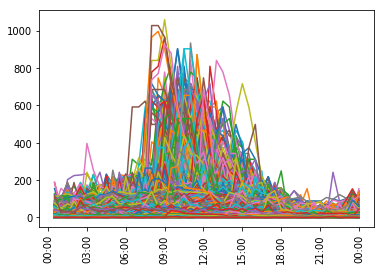

In [6]:
from datetime import datetime
import time
import matplotlib.dates as mdates

t = pd.Series(X.T.index).apply(lambda x: datetime.strptime(x,"%H:%M") if len(x)<6 else datetime.strptime('1900-01-02 00:00',"%Y-%m-%d %H:%M"))

ax = plt.subplot(111)
ax.plot(t,X.T)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
plt.xticks(rotation=90)

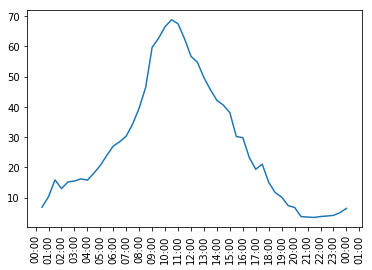

In [7]:
ax = plt.subplot(111)
ax.plot(t,X.T.mean(axis=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.xticks(rotation=90);

## Extracting features from time series - kNN with Sklearn

In [8]:
Xf = pd.DataFrame(data = X.T.describe().T,index=X.index)
Xf = Xf.drop(['count'],axis=1)
Xf.head()

,mean,std,min,25%,50%,75%,max
0,0.648542,4.493228,0.0,0.0,0.00,0.0000,31.13
1,5.836875,12.279004,0.0,0.0,0.00,0.0000,31.13
2,158.892708,207.612316,0.0,0.0,31.13,217.9100,622.60
3,112.197708,162.676419,0.0,0.0,31.13,163.4325,684.86
4,64.205625,112.407166,0.0,0.0,31.13,70.0425,591.47


In [9]:
x_train,x_test,y_train,y_test=train_test_split(Xf,y,test_size=0.2,stratify=y,random_state=23)

param={'n_neighbors':[1,4,6,10]}
clf = GridSearchCV(KNeighborsClassifier(),param,cv=5)
clf.fit(x_train, y_train)
y_true,y_pred=y_test,clf.predict(x_test)
print(clf.best_params_)
print(classification_report(y_true,y_pred))

{'n_neighbors': 6}
             precision    recall  f1-score   support

          0       0.93      0.60      0.73        72
          1       0.80      0.62      0.70        73
          2       0.56      0.89      0.68        72
          3       0.93      0.93      0.93        72

avg / total       0.81      0.76      0.76       289



## Whole time series - kNN with DTW

In [130]:
x_train,x_test,y_train,y_test=train_test_split(Xf,y,test_size=0.2,stratify=y,random_state=23)

def dtw(s1,s2,param):
    'distance between 2 time series (Dynamic Time Warping)'
    
    # placeholder for testing knn()
    dist=abs(s1-s2)
    
    return dist

def get_n(xtest,xtrain):
    'get matrix of distances of test (row) to train (column) set'
    nn = np.empty((len(xtest),len(xtrain)))
    for i in range(len(xtest)):
        for j in range(len(xtrain)):
            nn[i,j] = dtw(xtest[i],xtrain[j],'placeholder')
    return nn

def knn(xtest,xtrain,ytrain,k):
    codey =dict(zip(np.unique(ytrain),np.arange(len(np.unique(ytrain)))))
    ytrain = [codey[i] for i in ytrain]
    nn = get_n(xtest,xtrain) # all neighbours
    knn = np.argsort(nn)[:,:k] # indices of knns (no care for ties)
    yarr = np.matlib.repmat(ytrain,len(xtest),1) # array of corresponding y values
    ynn = np.array([np.take(yarr[i,:], knn_i[i,:]) for i in range(xtest)]) # categories of knn
    return ynn

In [128]:
knn(xtest,xtrain,ytrain,k):
    codey =dict(zip(np.unique(ytrain),np.arange(len(np.unique(ytrain)))))
    ytrain = [codey[i] for i in ytrain]
    nn = get_n(xtest,xtrain) # all neighbours
    knn = np.argsort(nn)[:,:k] # indices of knns (no care for ties)
    yarr = np.matlib.repmat(ytrain,len(xtest),1) # array of corresponding y values
    ynn = np.array([np.take(yarr[i,:], knn_i[i,:]) for i in range(xtest)]) # categories of knn
    return ynn

array([[1, 0],
       [1, 0],
       [1, 0],
       [0, 0]])

In [112]:
for i in range(len(xtest)):
    classfreq = np.bincount(ynn[i,:])
    winner = np.argmax(classfreq)
    [i if classfreq[[winner,:]]==i for i in 


[1 1]
[1 1]
[1 1]
[2]


## Clustering - kmeans sklearn

In [10]:
clu = KMeans(n_clusters=4)
clu.fit(Xf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [11]:
from collections import Counter
print('Label 0:',Counter(clu.predict(Xf[y==0])))
print('Label 1:',Counter(clu.predict(Xf[y==1])))
print('Label 2:',Counter(clu.predict(Xf[y==2])))
print('Label 3:',Counter(clu.predict(Xf[y==3])))

Label 0: Counter({0: 175, 3: 91, 2: 85, 1: 9})
Label 1: Counter({0: 203, 1: 160})
Label 2: Counter({1: 203, 0: 157, 3: 2})
Label 3: Counter({0: 338, 1: 21})


## Clustering - kmeans and DTW

In [ ]:
def dtw(s1,s2,param):
    
    return dist
dd
# gen centr.
